# Test of Selection mask

Assuming an additive term due to imaging systematics

$$
n_{g} = \bar{n} (1+\delta) + G(s) \\
n_{\rm pred} = \bar{n} + \hat{G}(s)
$$

I. Similar to Delubac et al.  (https://arxiv.org/pdf/1611.06934.pdf)

\begin{align}
w_{\rm sys} &= 1 + \frac{\bar{n} - n_{\rm pred}}{n_{g}}  \\
n_{g}*w_{\rm sys} &= \bar{n} + n_{g} - n_{\rm pred} \\
&= \bar{n}(1+\delta) + [G(s)-\hat{G}(s)] \\
&= \bar{n}(1+\delta)
\end{align}

II. Similar to Bautista et al. 2018
\begin{align}
w_{\rm sys} &= \frac{\bar{n}}{n_{\rm pred}} \\
n_{g}*w_{\rm sys} &= \frac{\bar{n} (1+\delta) + G(s)}{1 + \hat{G}(s)/\bar{n}}
\end{align}
assuming |$\hat{G}(s)/\bar{n}$| is < 1, we obtain
\begin{align}
n_{g}*w_{\rm sys} &= (\bar{n} (1+\delta) + G(s))~[1 - \hat{G}(s)/\bar{n} + (\hat{G}(s)/\bar{n})^{2}+...] \\
&= \bar{n}(1+\delta) - \hat{G}(s)(1+\delta) + G(s) + O(\hat{G}^{2})\\
&= \bar{n}(1+\delta) + [G(s) - \hat{G}(s) - \hat{G}(s)\delta] + O(\hat{G}^{2}) 
\end{align}
if we ignore the $O(\hat{G}^{2})$ terms, we obtain
$$
n_{g}*w_{\rm sys} = \bar{n}(1+\delta)
$$

In [1]:
''' import the required modules
'''
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft

import sys
# sys.path.insert(0, '/Users/rezaie/github/SYSNet/src')
sys.path.insert(0, '/Users/rezaie/github/LSSutils')

from scipy.stats import binned_statistic
from LSSutils.lab import AnaFast, MeanDensity, overdensity
from LSSutils.utils import histogram
from LSSutils.stats.cl import get_shotnoise

''' read the observed galaxy count, random count (aka fracgood), 
    predicted galaxy count (from NN)
    boolean mask for the pixels on the footprint, 
    and a fits table for imaging attributes.
    we only take the EBV map
'''
path = '/Volumes/TimeMachine/data/DR7/'
sysmaps = ft.read(f'{path}eBOSS.ELG.NGC.DR7.table.fits')
nran = hp.read_map(f'{path}frac.hp.256.fits', verbose=False)
ngal = hp.read_map(f'{path}eBOSS.ELG.NGC.DR7.cut.hp256.fits', verbose=False)
wnn = hp.read_map(f'{path}results/regression/nn_p/nn-weights.hp256.fits', verbose=False)
mask = hp.read_map(f'{path}mask.cut.hp.256.fits', verbose=False) > 0

ebv = np.zeros_like(ngal) # EBV map
ebv[sysmaps['hpind']] = sysmaps['features'][:, 0]

# original mask was with frac > 0.2
# t = ngal / (nran x ngal_tot / nran_tot)
t = overdensity(ngal, nran, nran>0.2, nnbar=True) 
wnn2 = np.ones_like(ngal)
m = t > 0
wnn2[m] = 1 + (1-wnn[m])/t[m]

wnn1 = 1./wnn

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


histograms of the weights

In [2]:
mask = nran > 0.2
for wnni in [wnn1[mask], wnn2[mask]]:
    print(np.percentile(wnni, [0, 1, 99, 100]))

[-1.42854275e+03  8.55955625e-01  1.55310544e+00  2.17629945e+04]
[-1.18168799  0.80400009  1.4564536  24.97700296]


Text(0.5, 0, '$w_{\\rm sys}$')

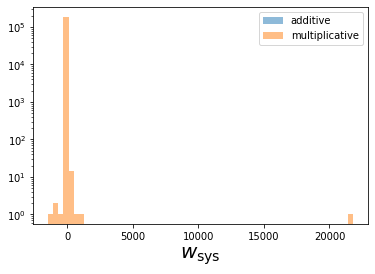

In [3]:
plt.hist(wnn2[mask], bins=60, alpha=0.5, label='additive')
plt.hist(wnn1[mask], bins=60, alpha=0.5, label='multiplicative')

plt.legend()
plt.yscale('log')
plt.xlabel(r'$w_{\rm sys}$', fontsize=20)

In [4]:
# initially, mask = nran > 0.2, in another block
mask1 = mask & (wnn1 > 0.5) & (wnn1 < 2.0)   
mask2 = mask & (wnn2 > 0.5) & (wnn2 < 2.0)

In [14]:
mask1.sum(), mask2.sum()

(185914, 186495)

Text(0.5, 0, '$w_{\\rm sys}$')

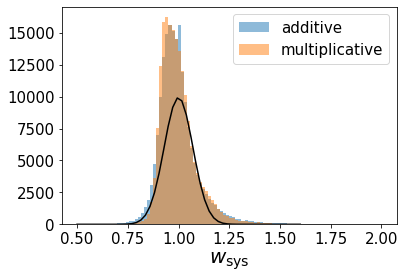

In [28]:
fpdf = lambda x, m, s: (1./np.sqrt(2*np.pi*s*s)) * np.exp(-1*((x-m)/(s))**2)

xg = np.linspace(0.5, 1.6)

_, b, _ = plt.hist(wnn2[mask2], bins=100, alpha=0.5, label='additive', align='mid')
plt.hist(wnn1[mask1], bins=b, alpha=0.5, label='multiplicative', align='mid')
plt.plot(xg, 2.5e3*fpdf(xg, 1, np.std(wnn1[mask1])), 'k-')
# plt.plot(xg, 3.8e3*fpdf(xg, 0.98, np.std(wnn1[mask])), 'k--')
plt.legend()
# plt.yscale('log')
# plt.ylim(1., 1.2e4)
plt.xlabel(r'$w_{\rm sys}$', fontsize=20)

Apply the weights on the galaxy count map, compute density contrast $\delta$, $C_{\ell}$

In [15]:
ngal1 = ngal * wnn1 # multiplicative
ngal2 = ngal * wnn2 # additive

# compute the density contrast
delta01 = overdensity(ngal, nran, mask1)
delta02 = overdensity(ngal, nran, mask2)

delta1 = overdensity(ngal1, nran, mask1)
delta2 = overdensity(ngal2, nran, mask2)

# compute mean density vs ebv
nbar = MeanDensity(ngal, nran, mask, ebv)
nbar.run()
nbar1 = MeanDensity(ngal1, nran, mask1, ebv)
nbar1.run()
nbar2 = MeanDensity(ngal2, nran, mask2, ebv)
nbar2.run()

# compute angular C_ell
af = AnaFast()
cl01 = af(delta01, nran, mask1)
cl02 = af(delta02, nran, mask2)
cl1 = af(delta1, nran, mask1)
cl2 = af(delta2, nran, mask2)

/Users/rezaie/anaconda3/envs/py3p6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


In [16]:
shotnoise = []
for ngal_i, mask_i in zip([ngal, ngal, ngal1, ngal2],
                          [mask1, mask2, mask1, mask2]):
    shotnoise.append(get_shotnoise(ngal_i, nran, mask_i))

In [17]:
shotnoise

[8.539519975252201e-07,
 8.55658387227114e-07,
 8.619420678921783e-07,
 8.642252887803628e-07]

left: Mean density vs EBV, right: angular power spectrum

[Text(0, 0.5, '$C_{\\ell}$'), Text(0.5, 0, '$\\ell$')]

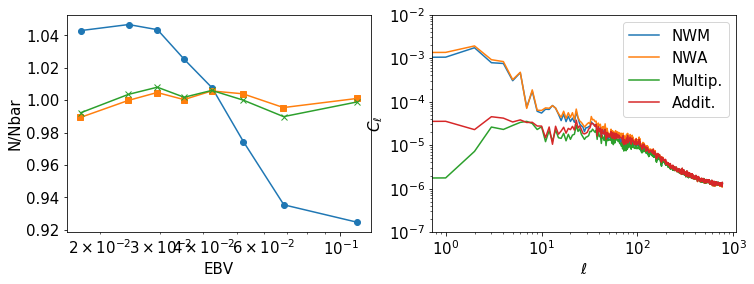

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

mk=['o', 's', 'x']
for i, nbar_i in enumerate([nbar, nbar1, nbar2]):
    ax[0].plot(nbar_i.output['bin_avg'], 
               nbar_i.output['nnbar'], 
               marker=mk[i])
    
ax[0].set(xlabel='EBV', ylabel='N/Nbar', xscale='log')

names = ['NWM', 'NWA', 'Multip.', 'Addit.']
for i, cli in enumerate([cl01, cl02, cl1, cl2]):
    ax[1].loglog(cli['l'], cli['cl'], label=names[i])
ax[1].set_ylim(1.0e-7, 1.0e-2)    
ax[1].legend()
ax[1].set(ylabel=r'$C_{\ell}$', xlabel=r'$\ell$')

ratio of the Cls

In [10]:
plt.rc('font', size=15)

[(0.85, 1.1),
 Text(0, 0.5, 'C$_{\\ell}^{\\rm X}$/C$_{\\ell}^{\\rm before}$'),
 Text(0.5, 0, '$\\ell$')]

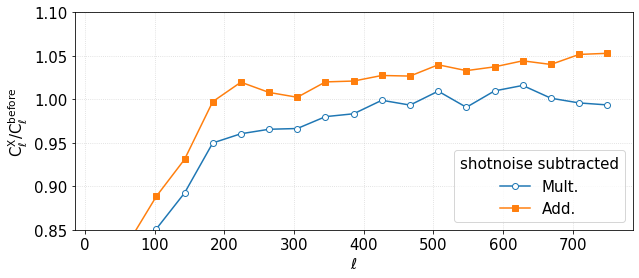

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

bins = np.linspace(1, 770, num=20)


elb0, clb01,_ = histogram(cl01['l'], cl01['cl']-shotnoise[0], bins=bins)
elb0, clb02,_ = histogram(cl02['l'], cl02['cl']-shotnoise[1], bins=bins)
elb1, clb1,_ = histogram(cl1['l'], cl1['cl']-shotnoise[2], bins=bins)
elb2, clb2,_ = histogram(cl2['l'], cl2['cl']-shotnoise[3], bins=bins)

assert np.array_equal(elb0, elb1)

ax.plot(elb0, clb1/clb01, marker='o', label='Mult.', mfc='w')
ax.plot(elb0, clb2/clb02, marker='s', label='Add.')

ax.legend(title='shotnoise subtracted')
ax.grid(True, ls=':', alpha=0.5)
ax.set(ylim=(0.85, 1.1), xlabel=r'$\ell$', 
       ylabel=r'C$_{\ell}^{\rm X}$/C$_{\ell}^{\rm before}$')

In [29]:
np.mean(wnn1[mask1]), np.mean(wnn1[mask]), np.mean(wnn2[mask2]), np.mean(wnn2[mask])

(1.0025714485961408, 1.1429712921570436, 1.0002123152337312, 1.010540288417593)